# Medical Insurance Cost Prediction

## Introduction

Healthcare costs are rising, and insurance companies need to estimate medical expenses based on patient demographic and lifestyle factors. Predicting medical insurance costs can help insurers set fair premiums and assist individuals in managing healthcare expenses.

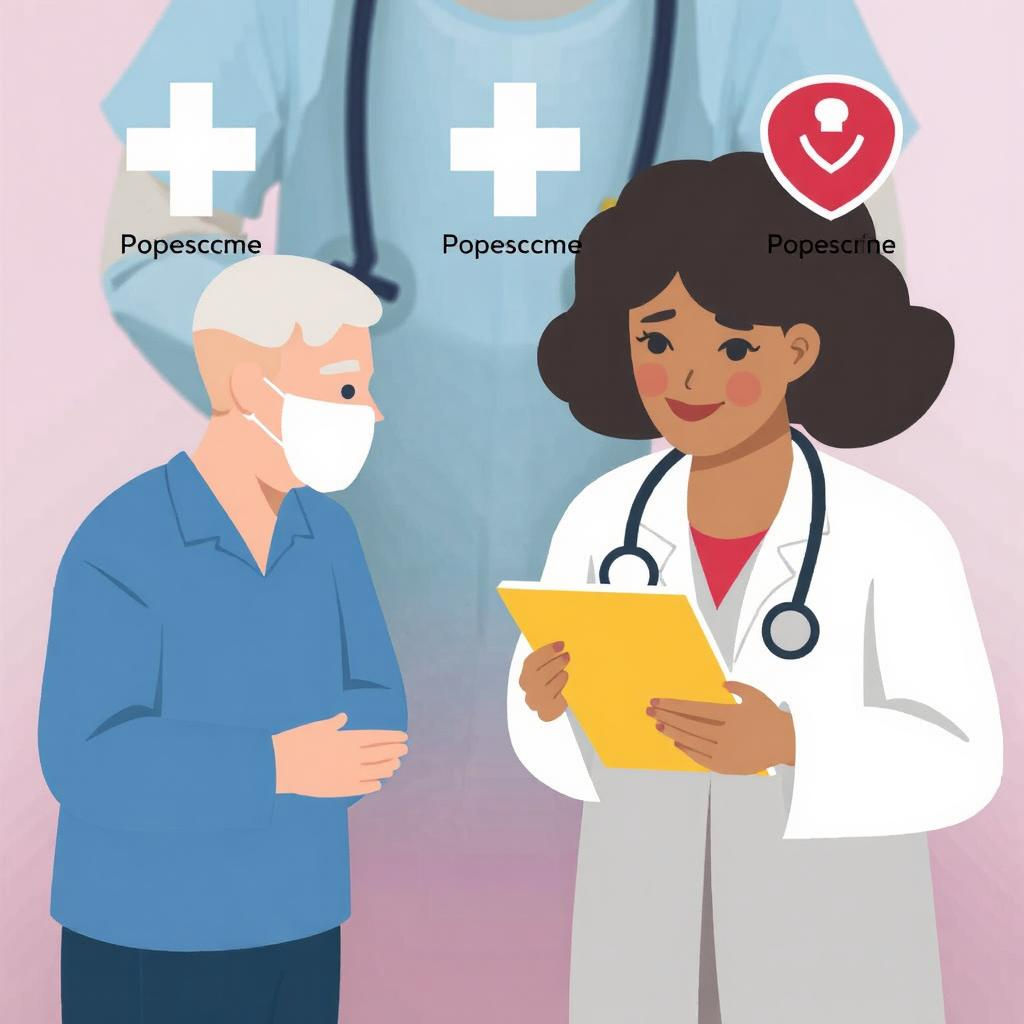


## Problem Statement

Our objective is to develop a predictive model to estimate individual medical insurance costs based on factors such as age, BMI, smoking status, number of dependents, gender, region. The goal is to identify key cost drivers and provide accurate cost estimates to help insurers and policy makers optimize pricing strategies.

## Libraries

We start by importing the necessary libraries and setting up some parameters for the whole notebook(such as parameters for the plots etc.).We will mainly use:
* Pandas for handling and analysing data
* Seaborn and Matplotlib for data visualisation


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

random_state = 42

print('Libraries loaded!')

Libraries loaded!


## Getting the Data

Importing the csv file


In [2]:
df = pd.read_csv(r'C:\Users\NATHAN\Downloads\insurance (1).csv',encoding='utf-8',encoding_errors='ignore')
print('DataFrame loaded successfully!')
print('The dataframe has {} rows and {} columns'.format(df.shape[0],df.shape[1]))
df.head()

DataFrame loaded successfully!
The dataframe has 1338 rows and 7 columns


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We need to split the data into train and test sets, as we will perform EDA, data preprocessing on the train set, which will then be used to train the model and evaluate that very model on the test set

In [3]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(df,test_size=0.2,random_state=random_state)

train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

print('Train set: {} rows and {} columns'.format(train_df.shape[0],train_df.shape[1]))
print('Test set: {} rows and {} columns'.format(test_df.shape[0],test_df.shape[1]))

Train set: 1070 rows and 7 columns
Test set: 268 rows and 7 columns


In [4]:
#Saving the split for the preprocessing stage
train_df.to_csv('med_train.csv',index = False)
test_df.to_csv('med_test.csv', index = False)

## A Quick Look at Our Data

The aim of this section is to familiarize ourselves with the data. We will focus entirely on the training set and forget about the test set completely, which shows we won't add data snooping bias

In [5]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
0,46,female,19.95,2,no,northwest,9193.83850
1,47,female,24.32,0,no,northeast,8534.67180
2,52,female,24.86,0,no,southeast,27117.99378
3,39,female,34.32,5,no,southeast,8596.82780
4,54,female,21.47,3,no,northwest,12475.35130


The explanation of each feature is given below:

* Age: Age of the primary beneficiary.
* Sex: Gender of the beneficiary (male/female).
* BMI: Body mass index, a measure of body fat based on height and weight.
* Children: Number of dependents covered by the insurance.
* Smoker: Smoking status of the beneficiary (yes/no).
* Region: Residential area in the U.S. (northeast, southeast, southwest, northwest).
* Charges: Individual medical costs billed by health insurance.

### Missing Values

We will now check for missing values

In [6]:
missing_counts = train_df.isnull().sum().sort_values(ascending=False)
missing_percent = ((train_df.isnull().sum()*100)/train_df.shape[0]).sort_values(ascending=False)

missing_df = pd.concat([missing_counts,missing_percent],axis=1,keys=['Counts','%'])

display(missing_df.head(7).style.background_gradient(cmap='Reds',axis=0))

,Counts,%
age,0,0.000000
sex,0,0.000000
bmi,0,0.000000
children,0,0.000000
smoker,0,0.000000
region,0,0.000000
charges,0,0.000000


There are no missing values in this split, lets check for the test split

In [7]:
missing_counts = test_df.isnull().sum().sort_values(ascending=False)
missing_percent = ((test_df.isnull().sum()*100)/test_df.shape[0]).sort_values(ascending=False)

missing_df = pd.concat([missing_counts,missing_percent],axis=1,keys=['Counts','%'])

display(missing_df.head(7).style.background_gradient(cmap='Reds',axis=0))

,Counts,%
age,0,0.000000
sex,0,0.000000
bmi,0,0.000000
children,0,0.000000
smoker,0,0.000000
region,0,0.000000
charges,0,0.000000


Therefore the whole dataset is free of missing values!

### Duplicate Values

Let's check whether there are duplicate values

In [8]:
duplicated_rows = train_df.duplicated().sum()

print('Number of dupliacted rows {}'.format(duplicated_rows))

Number of dupliacted rows 0


There are no duplicate instances

## Data Types

There are two types of variables:

1. *Numeric* Variables that can be expressed on a numeric scale. There are two basic categories of numeric variables:

* Continuous : can take any value within a range/interval(e.g person's height)
* Discrete : can take only certain integer values(e.g number of students)

2. *Categorical* variables that can take only a fixed set of values that correspond to a set of possible categories(e.g. gender,country names, etc.).
Special cases of categorical variables are:
* Nominal : Values follow no sort of order
* Ordinal : values follow a certain order

Different visualisation techniques apply to different features, so it's useful to isolate numeric and categorical variables


In [9]:
numeric_atts = train_df.select_dtypes(exclude=['object'])
cat_atts = train_df.select_dtypes(include=['object'])

print('Number of numeric columns: ',len(numeric_atts.columns))
print('Number of Categorical columns:',len(cat_atts.columns))


Number of numeric columns:  4
Number of Categorical columns: 3


## Exploratory Data Analysis

### Numeric Data

By calling the hist() method we can plot a histogram for each numeric attribute:

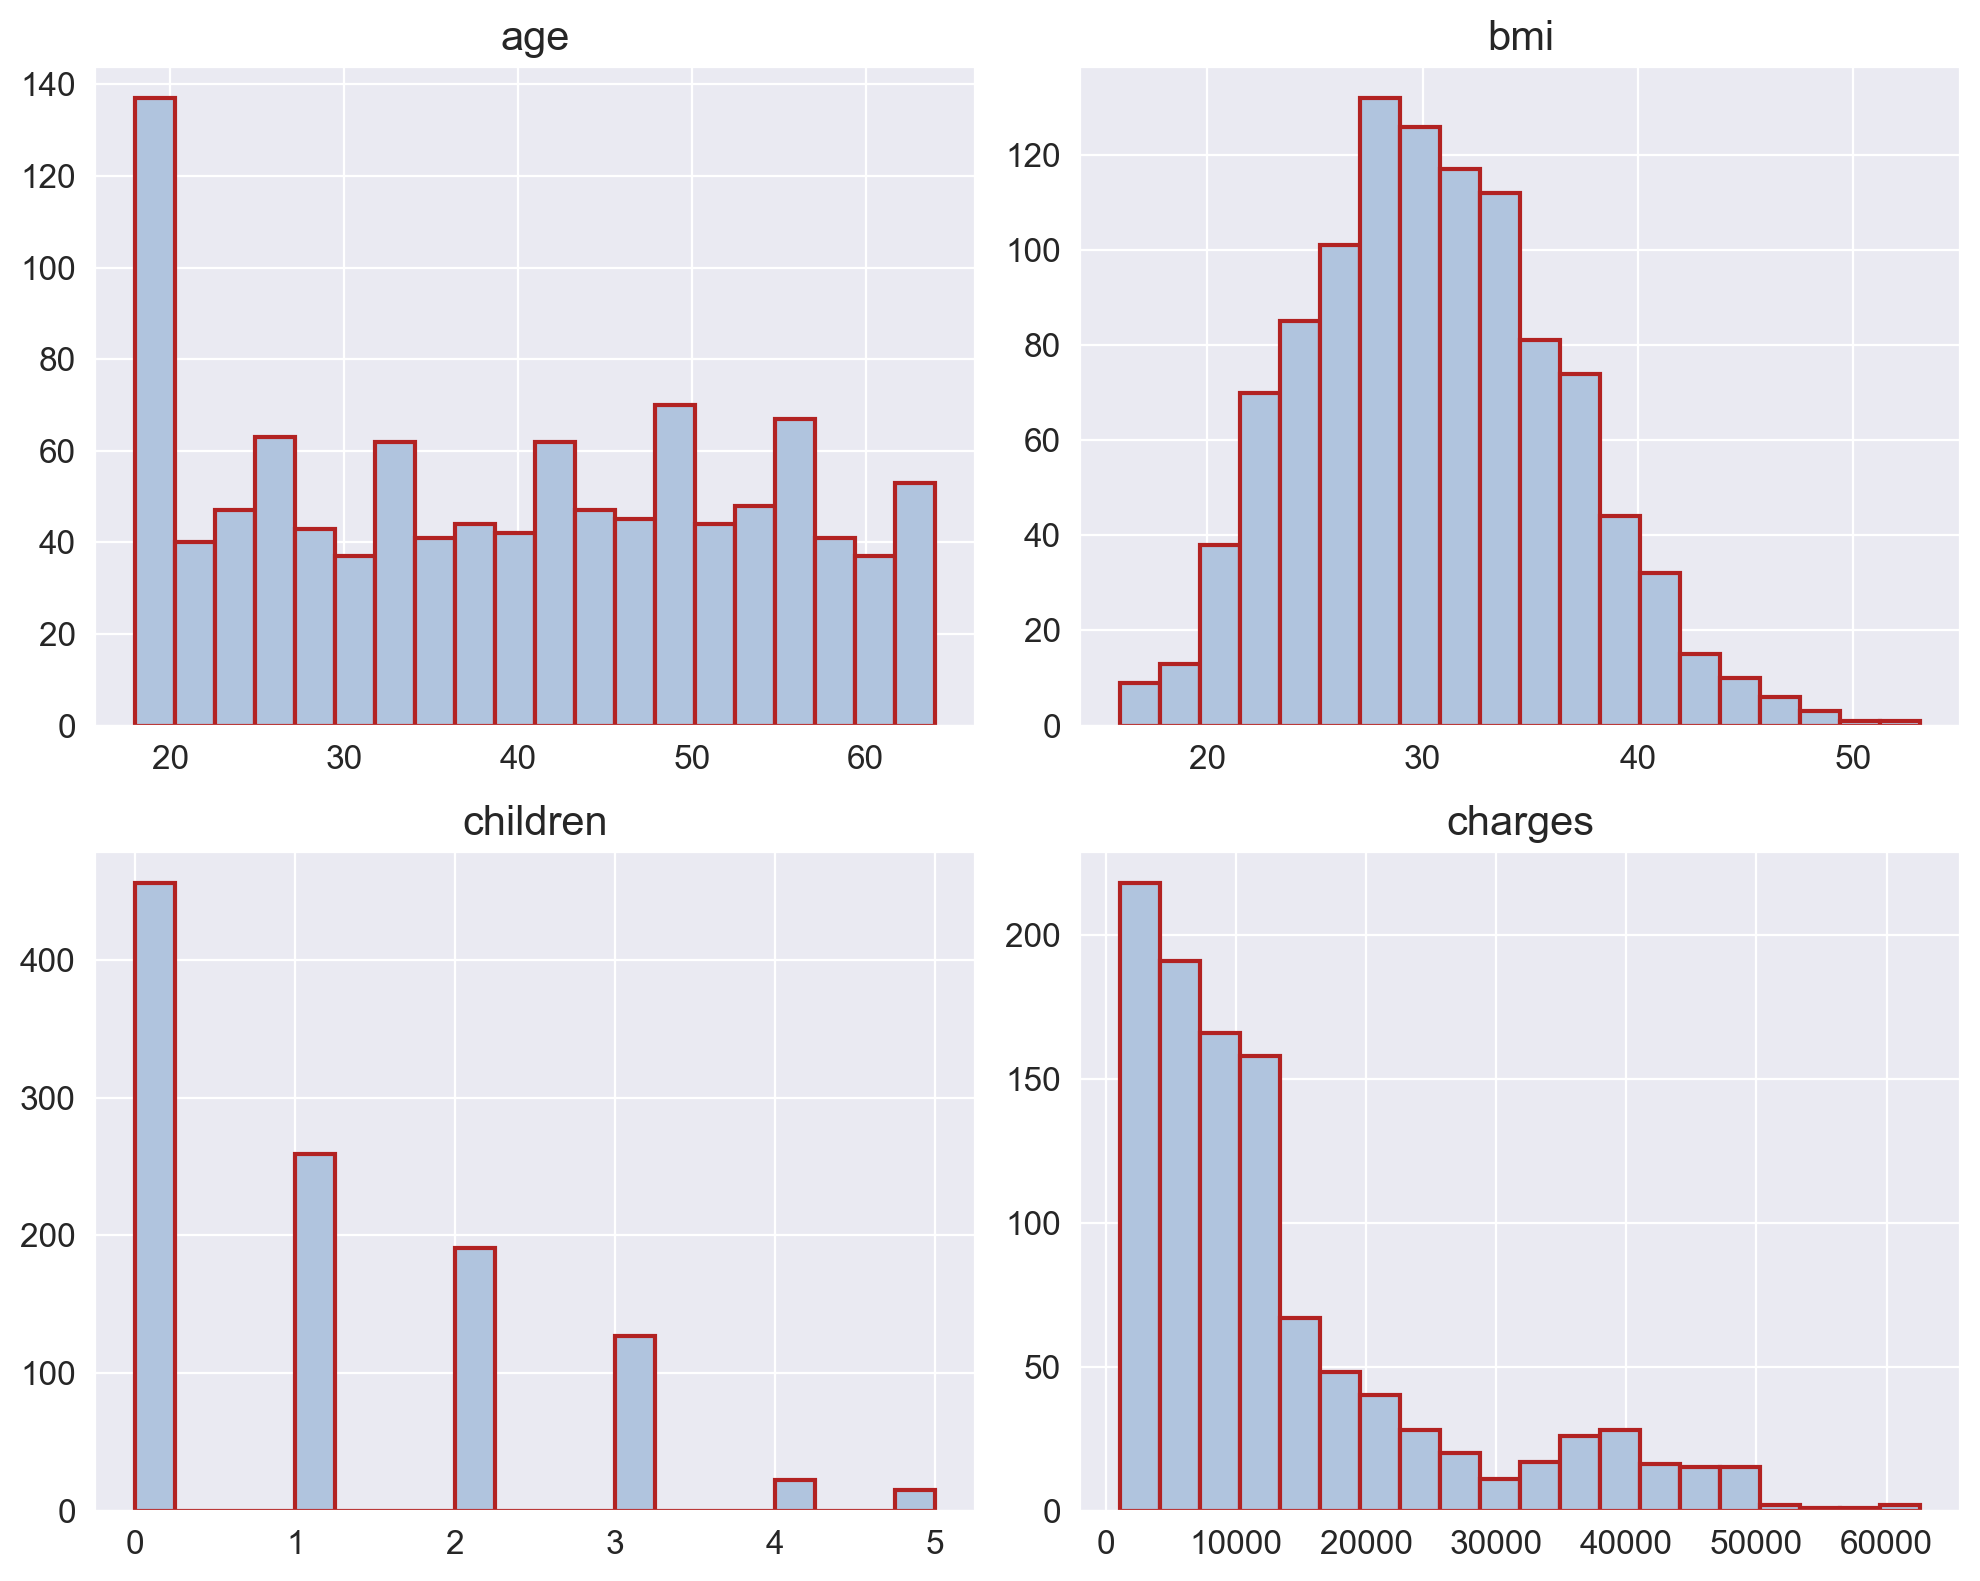

In [10]:
numeric_atts.hist(figsize=(10,8),layout=(2,2),bins=20,color='lightsteelblue',
                  edgecolor='firebrick',linewidth=1.5)
plt.tight_layout()

* children is a discrete feature as it can take on certain values, and as we can see majority of the customers either are childless or have upto 3 children
* Age is mostly uniform except around 20, which indicates that most of the customers are in their early 20's
* bmi is a fairly normal distribution with a slight skew to the right
* charges exponentially decrease which indicate that amount spend on most of the customers are in the 0-20000 range with amounts higher than 20000 being less frequent and above 50000 being a rare occurence

#### Low Variance

We will know try to identify features with a low variance; let us write a function for that:

In [11]:
def low_variance(df, thd=0.9):

    columns = []
    for column in df.columns:
        values = df[column].value_counts(normalize=True)

        if (values>thd).sum() > 0:
            columns.append(column)

    return columns


In [12]:
thd = 0.9
columns_low_var = low_variance(numeric_atts, thd)

print('Numeric attributes with mostly the same value (>{}%)'.format(thd*100))
print(columns_low_var,sep=',\n')

Numeric attributes with mostly the same value (>90.0%)
[]


We can come to a conclusion that there are no features with a low variance

Let's plot a boxplot for every continuous attribute : 



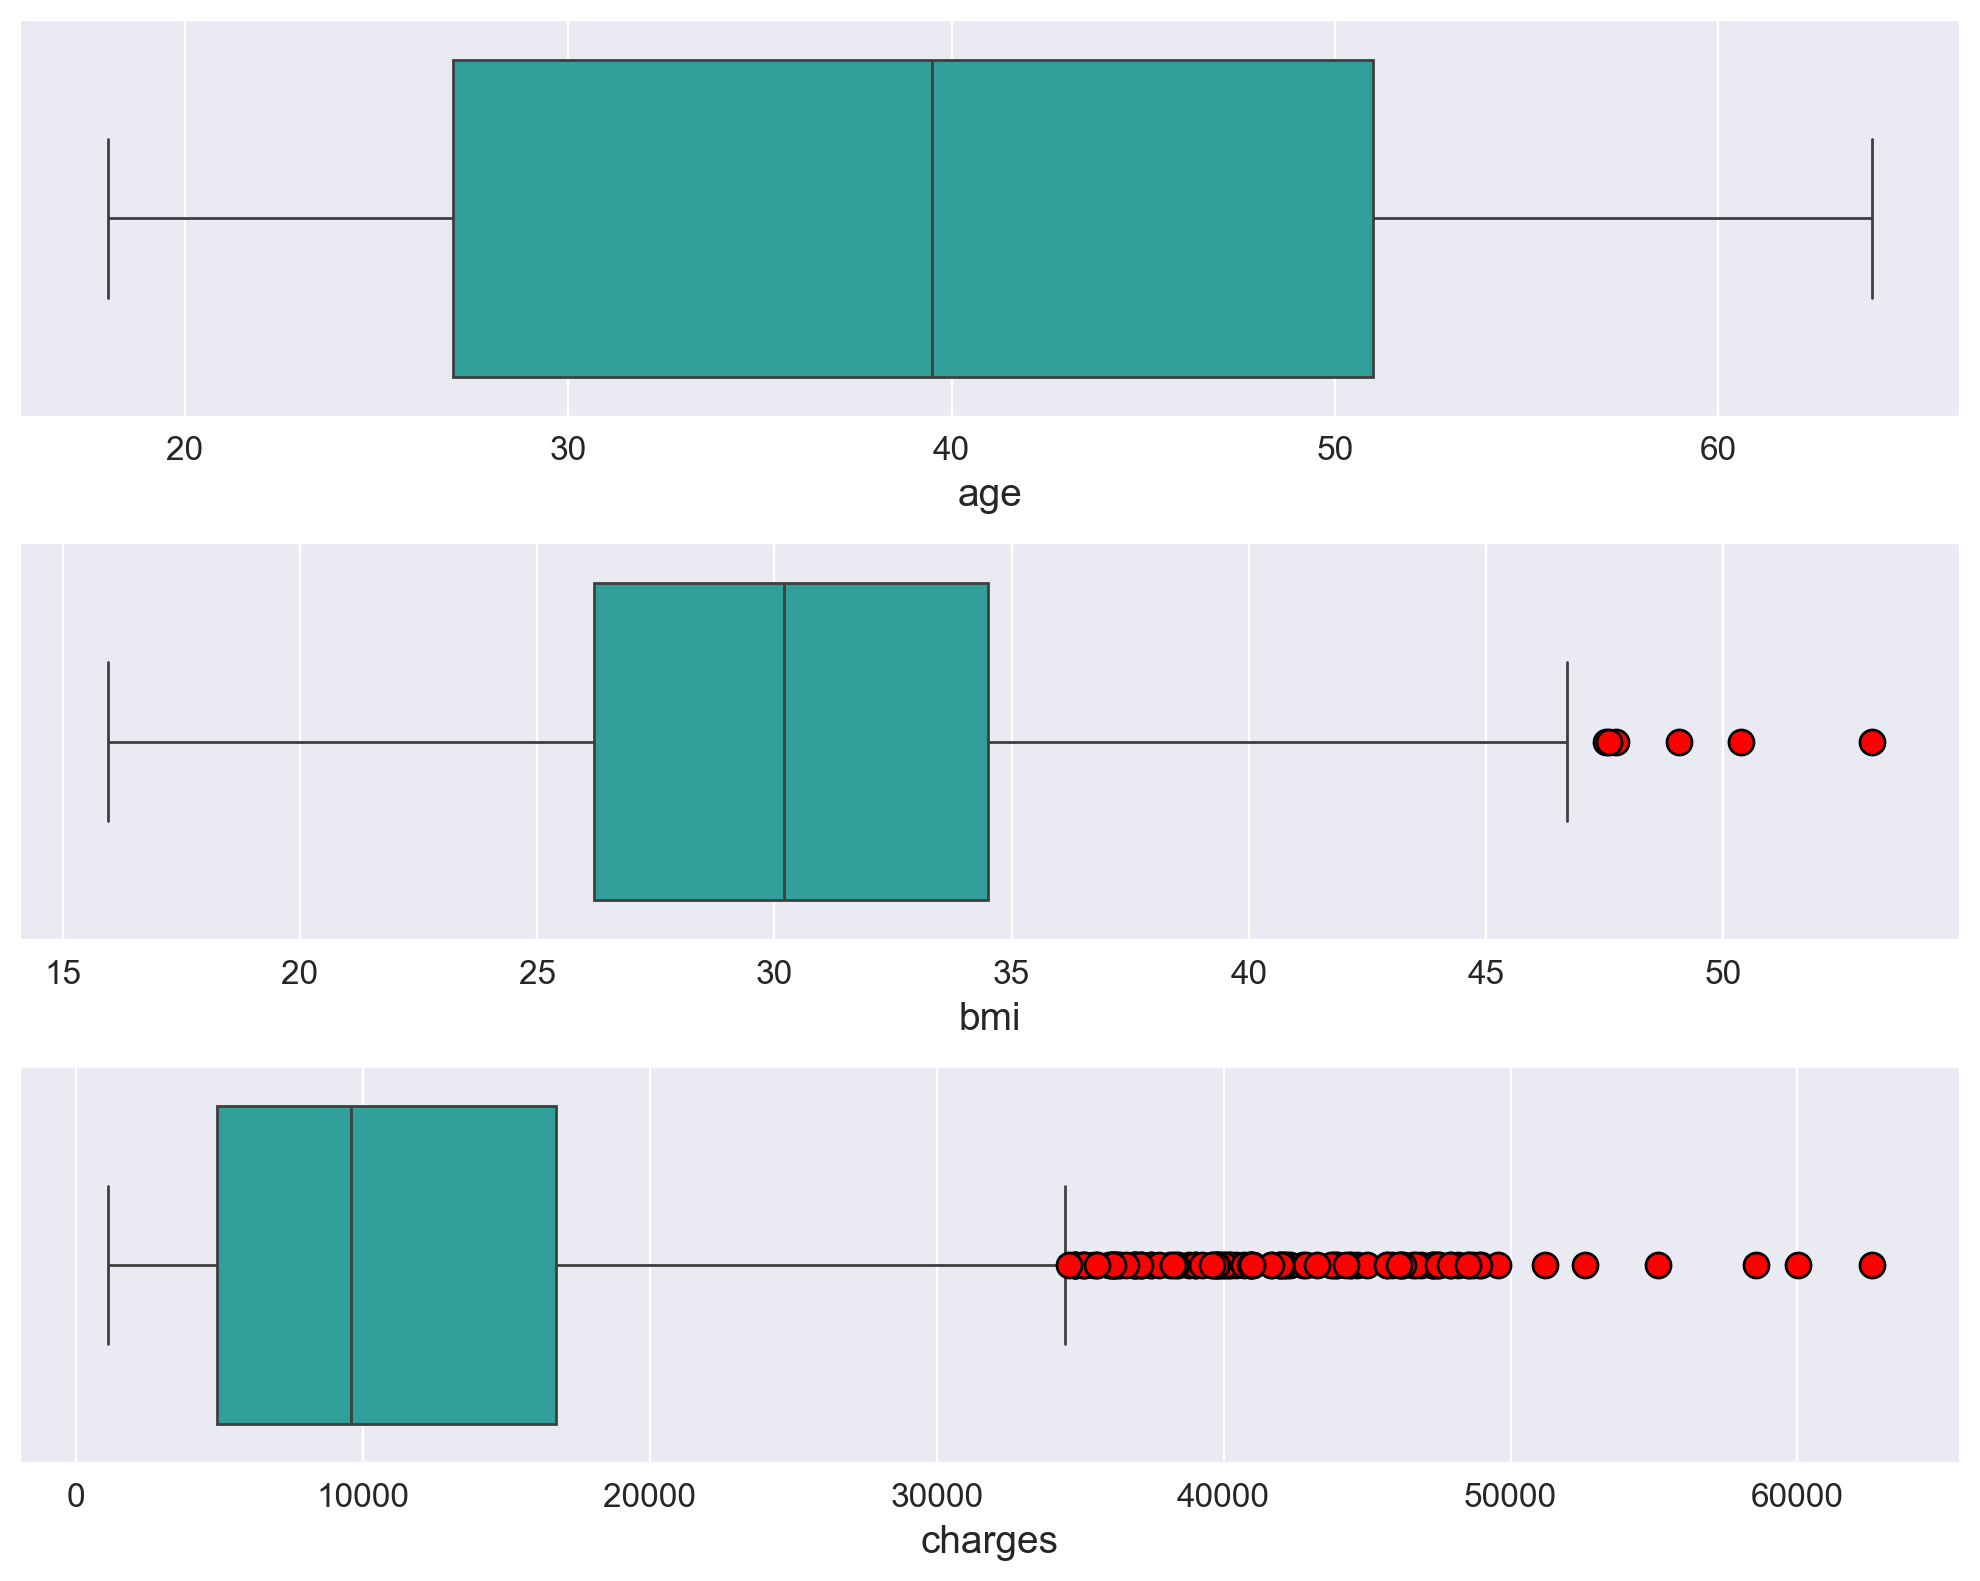

In [13]:
discrete_n_atts = ['children']
continuous_n_atts = ['age','bmi','charges']

fig = plt.figure(figsize=(10,8))
flierprops = dict(marker='o',markerfacecolor='r',markeredgecolor='k',
                  markersize=9)

for index,column in enumerate(continuous_n_atts):

    plt.subplot(3,1,index+1)
    sns.boxplot(x=column,data=train_df,color='lightseagreen',flierprops=flierprops)

fig.tight_layout()

* age has no outliers
* bmi has a few, whereas charges has a huge amount of outliers, which will we solved by log transformation and outlier processing steps

### Charges

Let's have a look at the target variable in greater detail

Skewness: 1.52
Kurtosis: 1.62


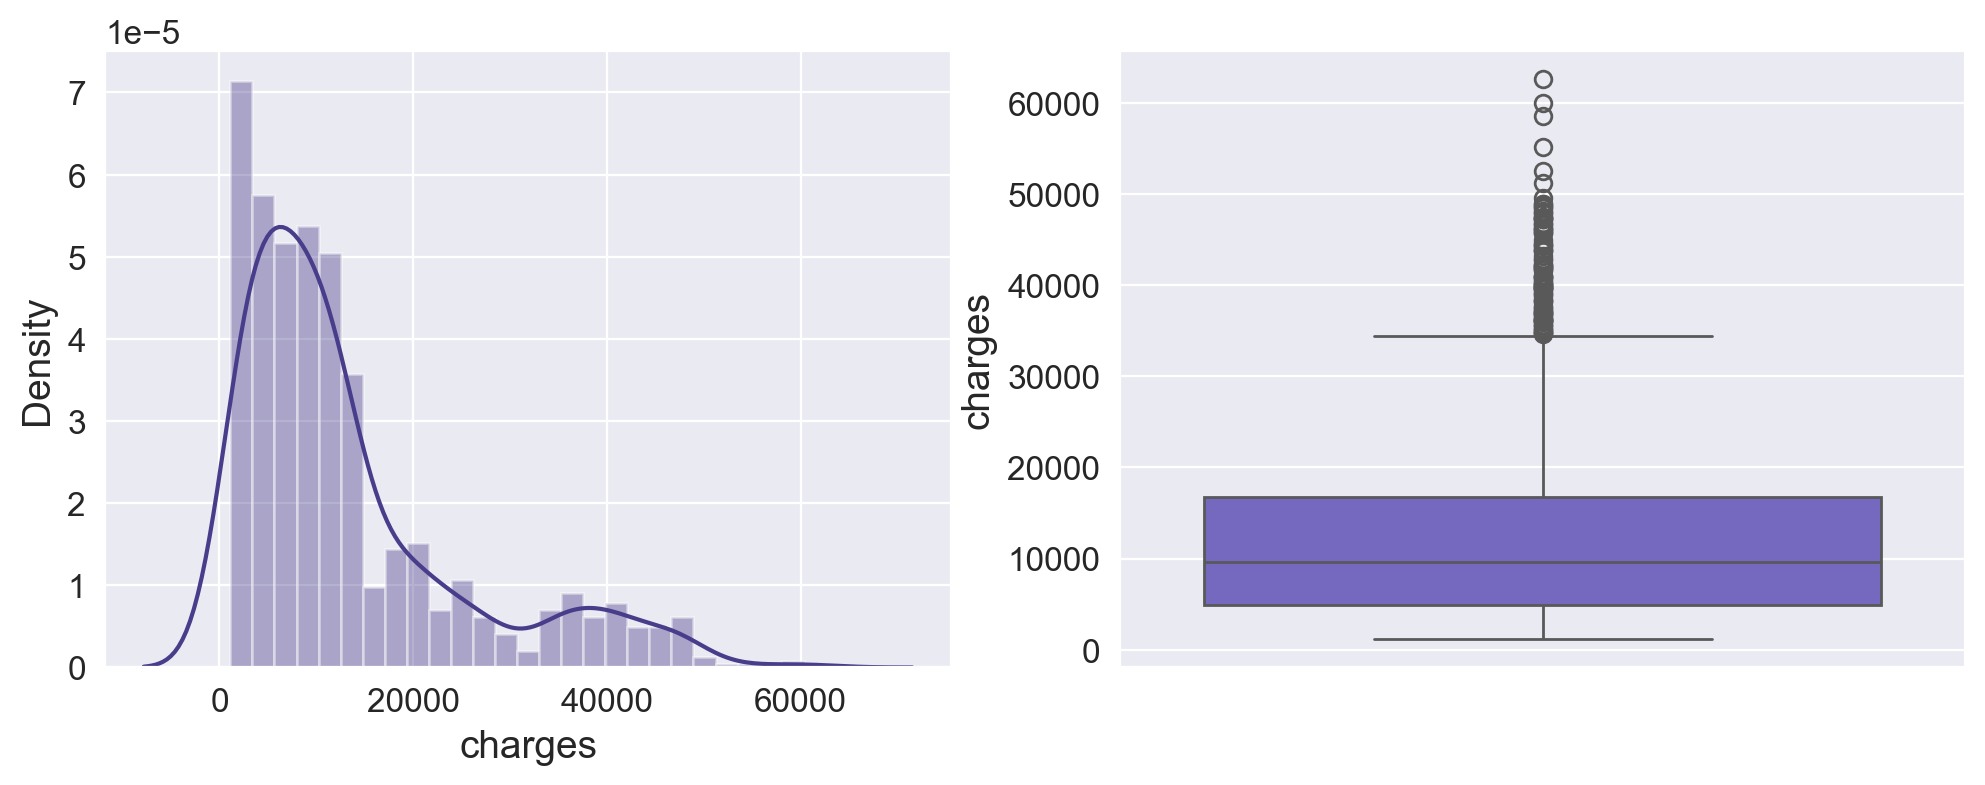

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sns.distplot(train_df['charges'],color='darkslateblue',ax=ax1)
sns.boxplot(train_df['charges'],color='slateblue',ax=ax2)

#Skewness and kurtosis
print('Skewness: {}'.format(np.round(train_df['charges'].skew(),2)))
print('Kurtosis: {}'.format(np.round(train_df['charges'].kurt(),2)))

* Our target variable has a huge number of outliers and significantly deviates from the symmetric bell curve we would expect from a normal distribution
* Specifically, it is right skewed(right-tailed)
* We will correct this by performing log-transformation on the data

Skewness : -0.12
Kurtosis : -0.59


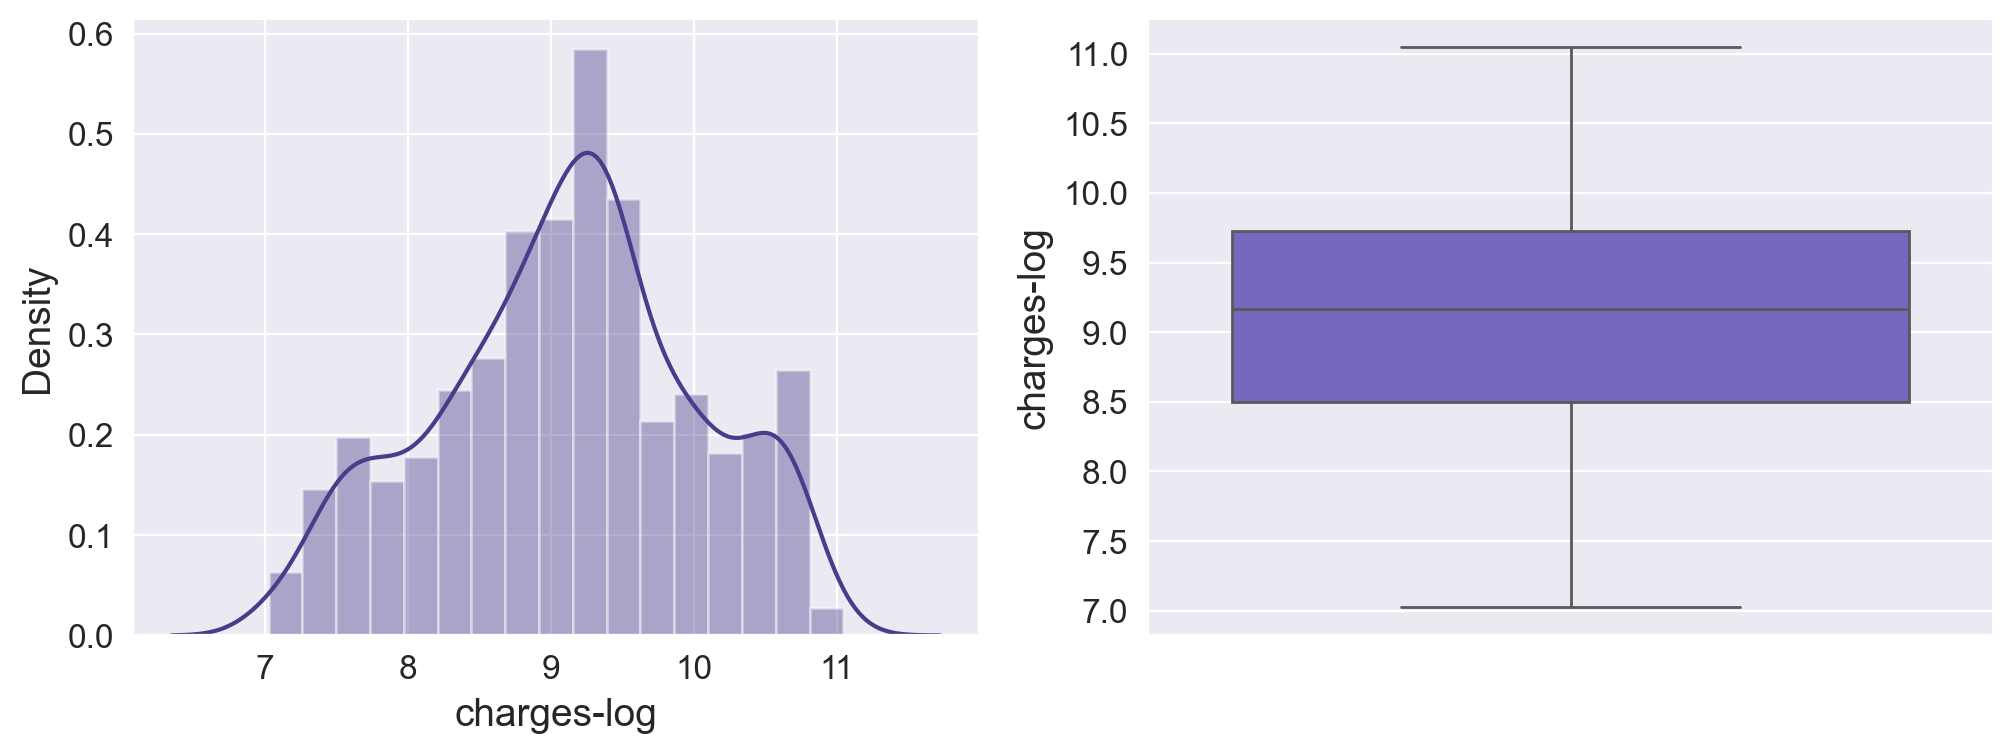

In [15]:
train_df['charges-log'] = np.log1p(train_df['charges'])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sns.distplot(train_df['charges-log'],color='darkslateblue',ax=ax1)
sns.boxplot(train_df['charges-log'],color='slateblue',ax=ax2)

#Skewness and kurtosis
print('Skewness : {}'.format(np.round(train_df['charges-log'].skew(),2)))
print('Kurtosis : {}'.format(np.round(train_df['charges-log'].kurt(),2)))

* We can see that our target variable appears more normally distributed now
* Both the skewness(measure of asymmetry) and kurtosis(measure of tailedness) of the distribution decreased after the transformation

### Categorical Data

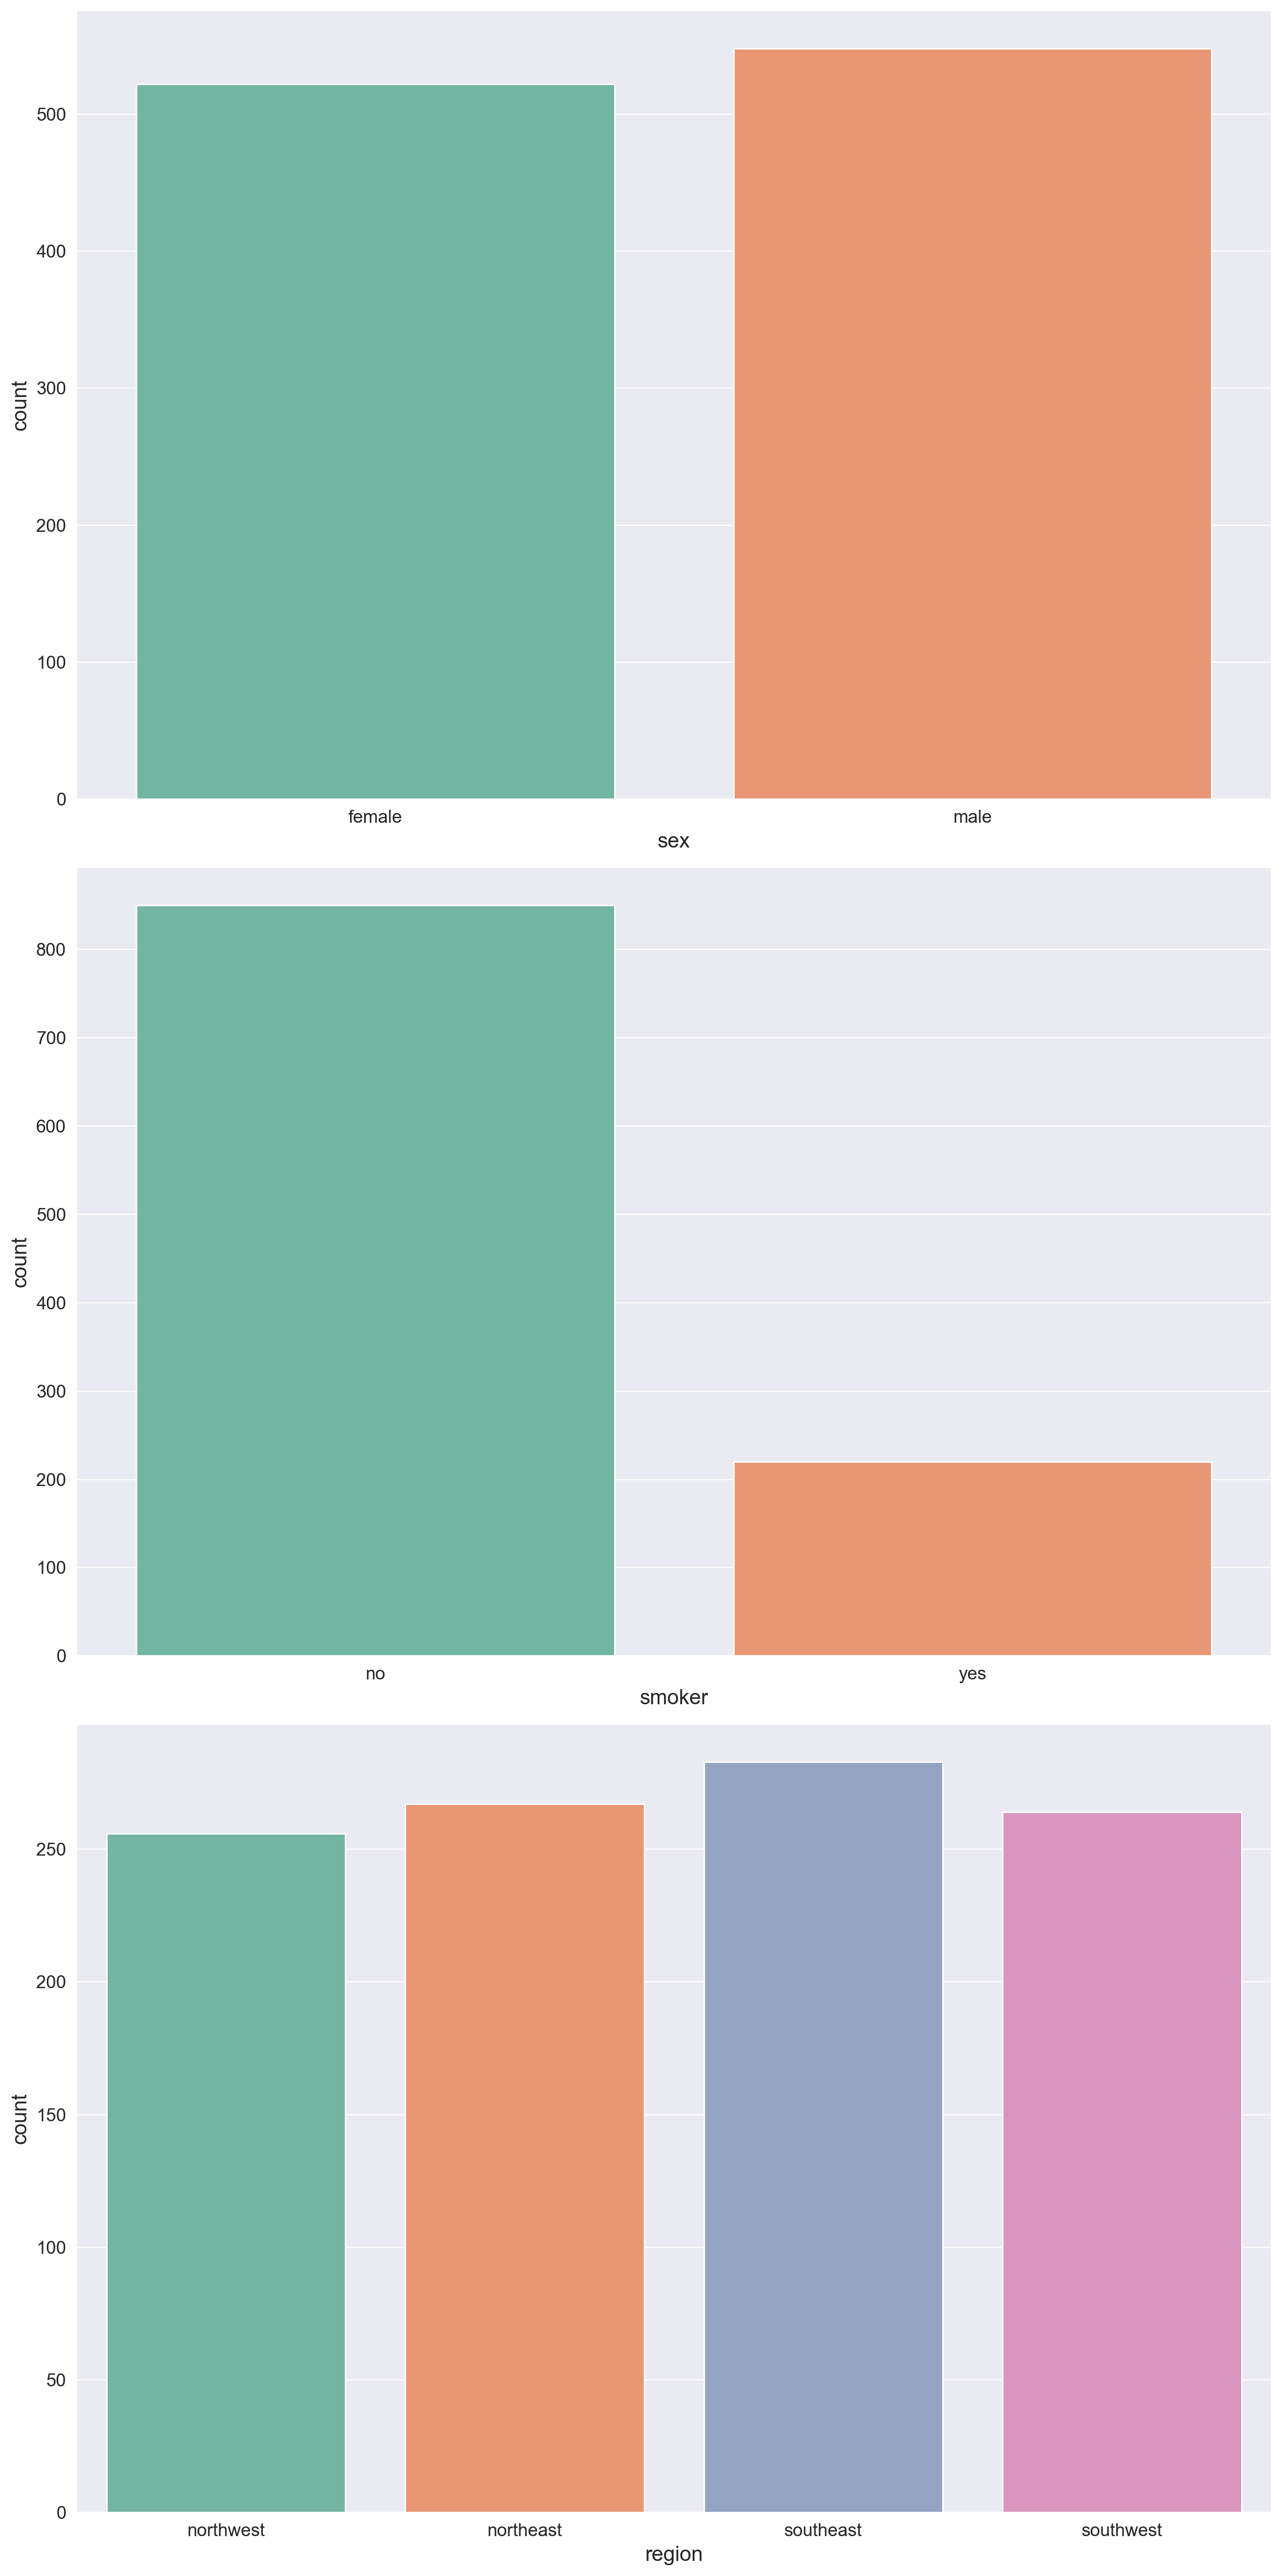

In [16]:
fig = plt.figure(figsize=(12,24))

for index,column in enumerate(cat_atts):

    plt.subplot(3,1,index+1)
    sns.countplot(x=column,data=train_df,palette='Set2')

fig.tight_layout()

* The first plot indicates that male customers are more likely to insure themselves 
* From the second plot, we can see that a high percentage of the customers do not smoke, which can lower the risk of life-threatning ailments and lower premium costs on their part
* The final plot indicates that the number of customers are more or less the same from each of the four regions

In [17]:
# Checking which categorical columns have low variance
thd = 0.9

columns_low_var = low_variance(cat_atts)

print('Categorical attributes with mostly the same value (>{}%)'.format(thd*100))
print(*columns_low_var,sep=',\n')


Categorical attributes with mostly the same value (>90.0%)



* We can say that no categorical columns have low variance

### Bivariate Analysis

So far, we have examined each feature individually, Bivariate analysis refers to the analysis of bivariate data with the goal of determining if a relationship between two features exists.

In [18]:
correlations = numeric_atts.select_dtypes(exclude = ['object']).corr()
correlations = correlations[['charges']].sort_values(by=['charges'],ascending=False)
correlations.style.background_gradient(cmap='Blues',axis=0)


,charges
charges,1.000000
age,0.281721
bmi,0.197316
children,0.071885


* Age has a weak to moderate relationship
* Bmi has a weak relationship
* Children has a very weak relationship with charges

Additionally, we can extract information about correlations by using regplot and extract the type of relationships

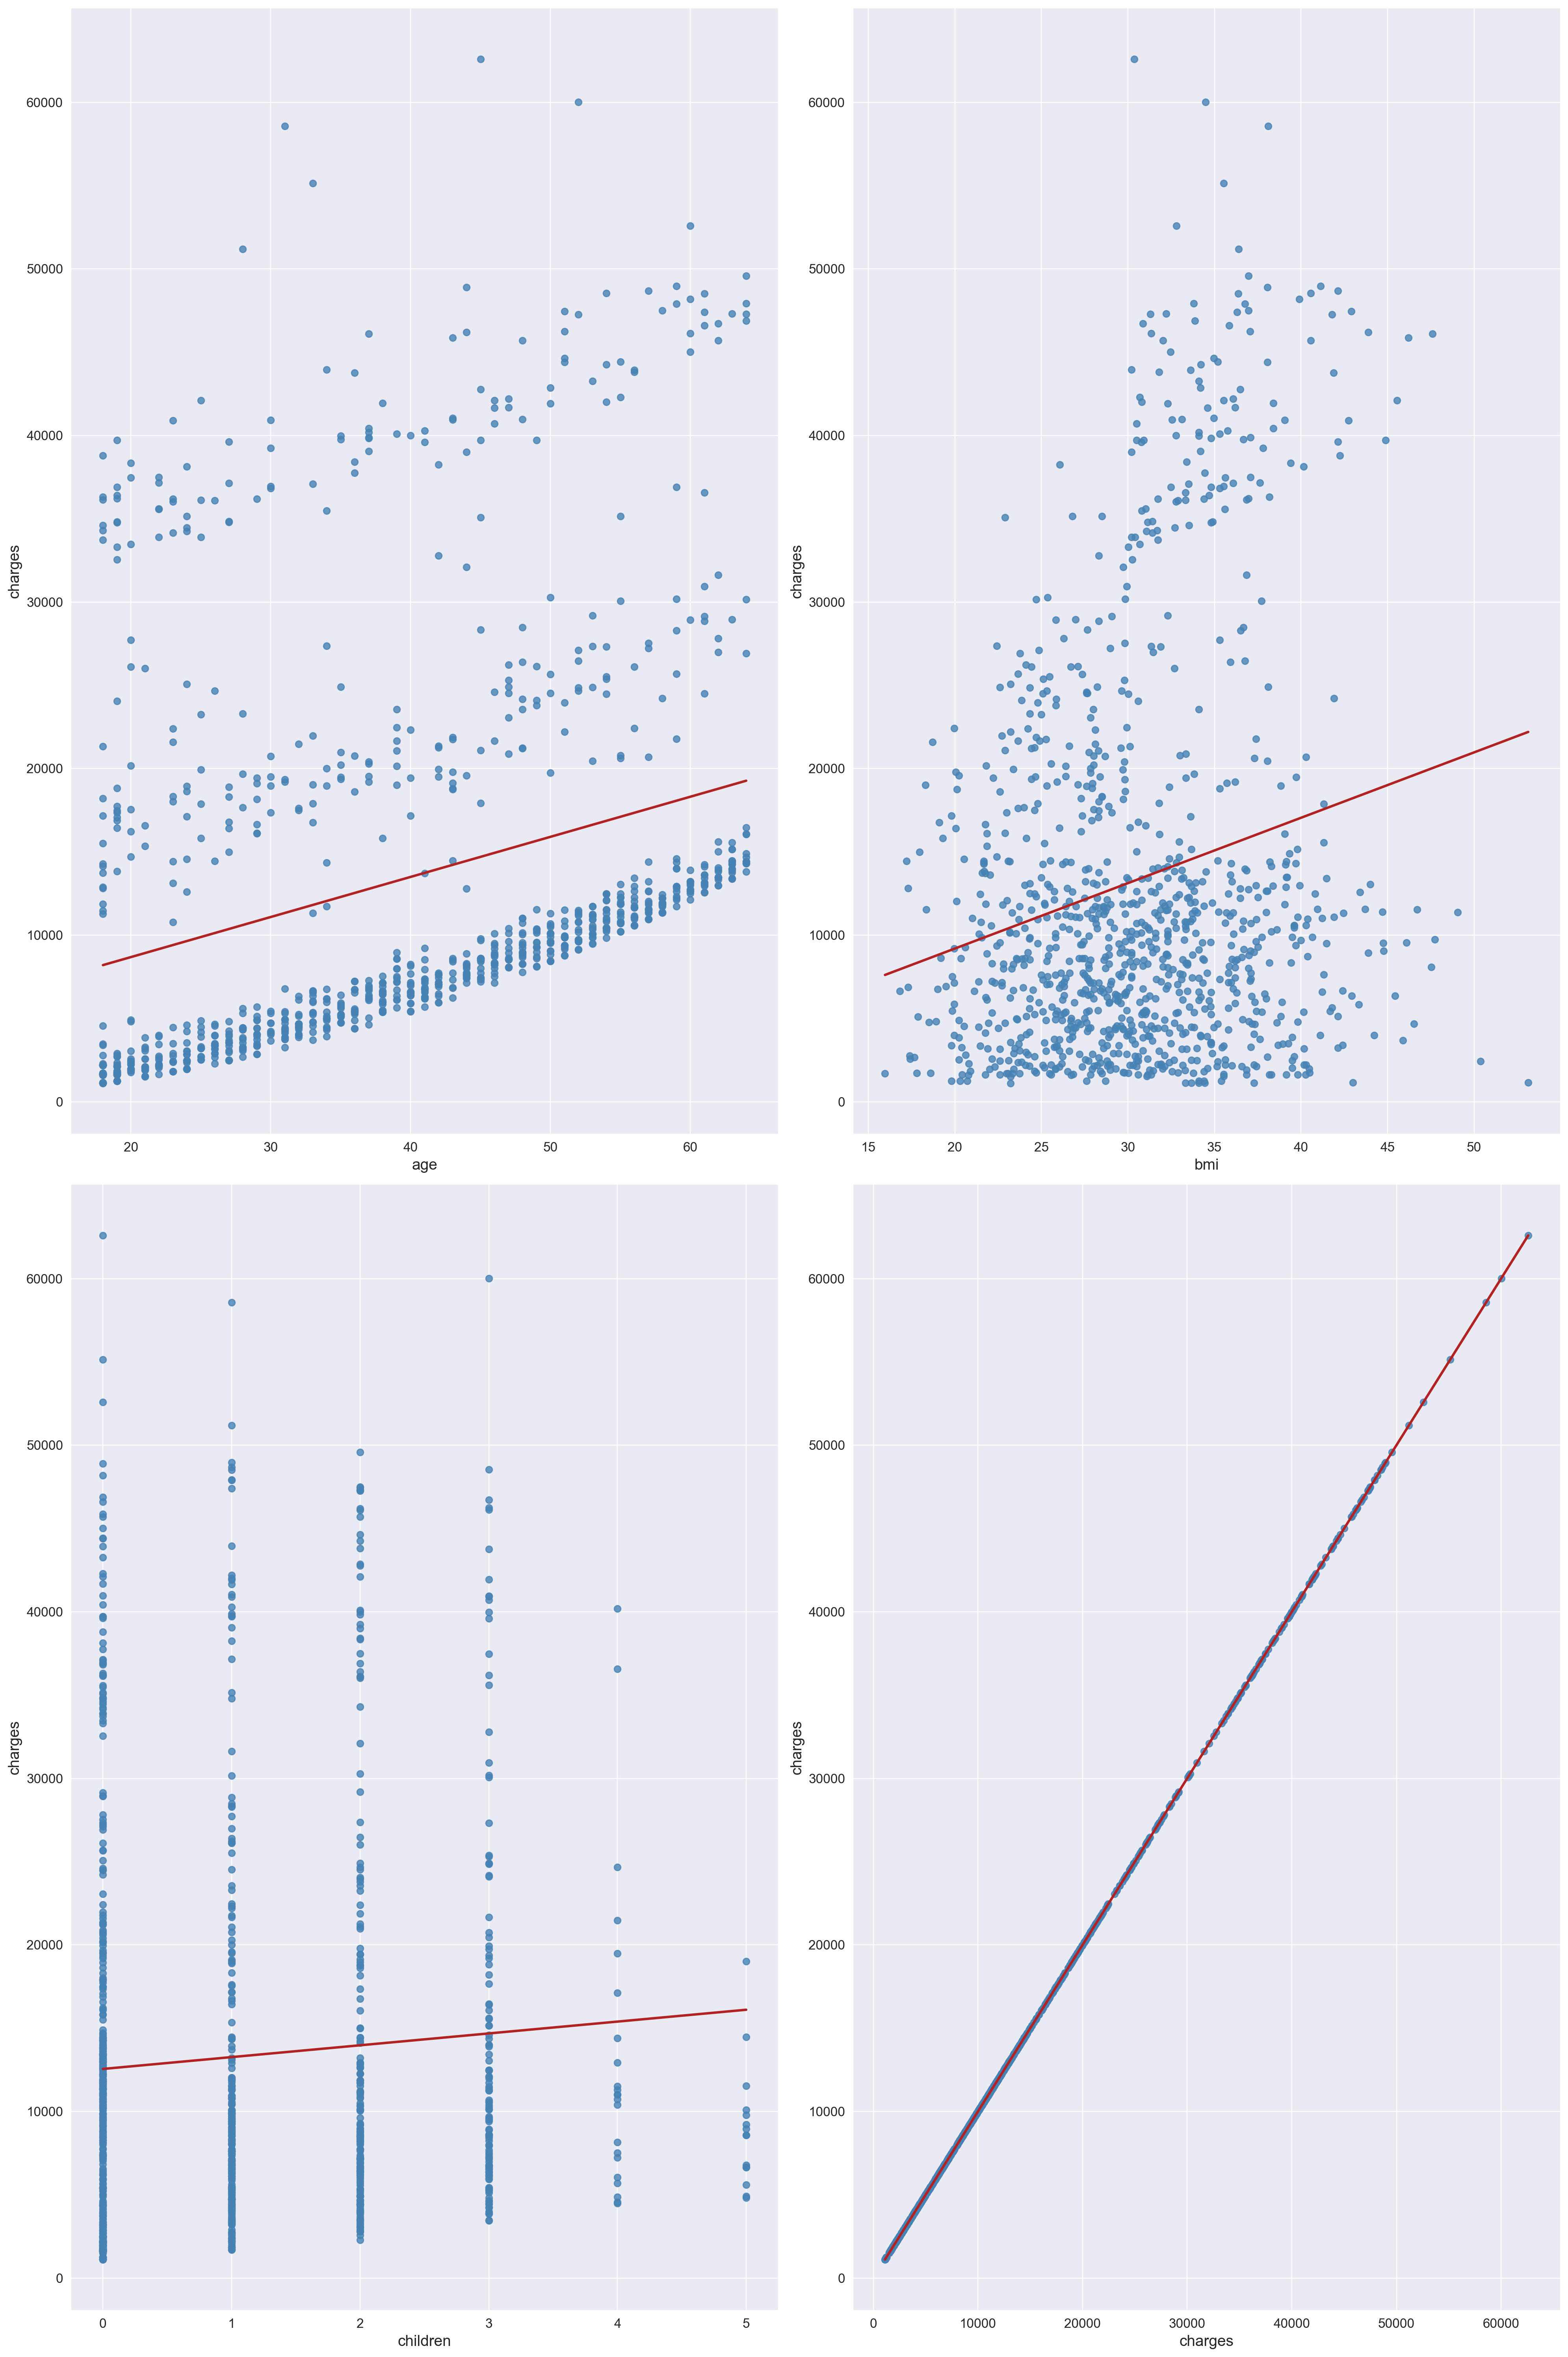

In [19]:
fig = plt.figure(figsize = (20,30))

for index,column in enumerate(numeric_atts.columns):

    plt.subplot(2,2,index+1)
    sns.regplot(x=column,y='charges',data=train_df,ci=None,color='steelblue',line_kws={'color':'firebrick'})

fig.tight_layout()

There is no linear relationship between the independent variables and dependent variables

Finally, we can plot a **correlation matrix** which can help us identify **multicollinear features**

'Multicollinearity is the occurrence of high intercorrelations among two or more independent variables in a multiple regression model'.

The same source explaing why we should avoid it: 'Multicollinearity can lead to skewed or misleading results when a researcher or analyst attempts to determine how well each independent variable can be used most effectively to predict or understand the dependent variable in a statistical model.'

In the following figure, I have used a mask so that only correlations > 0.75 are highlighted:





<Axes: >

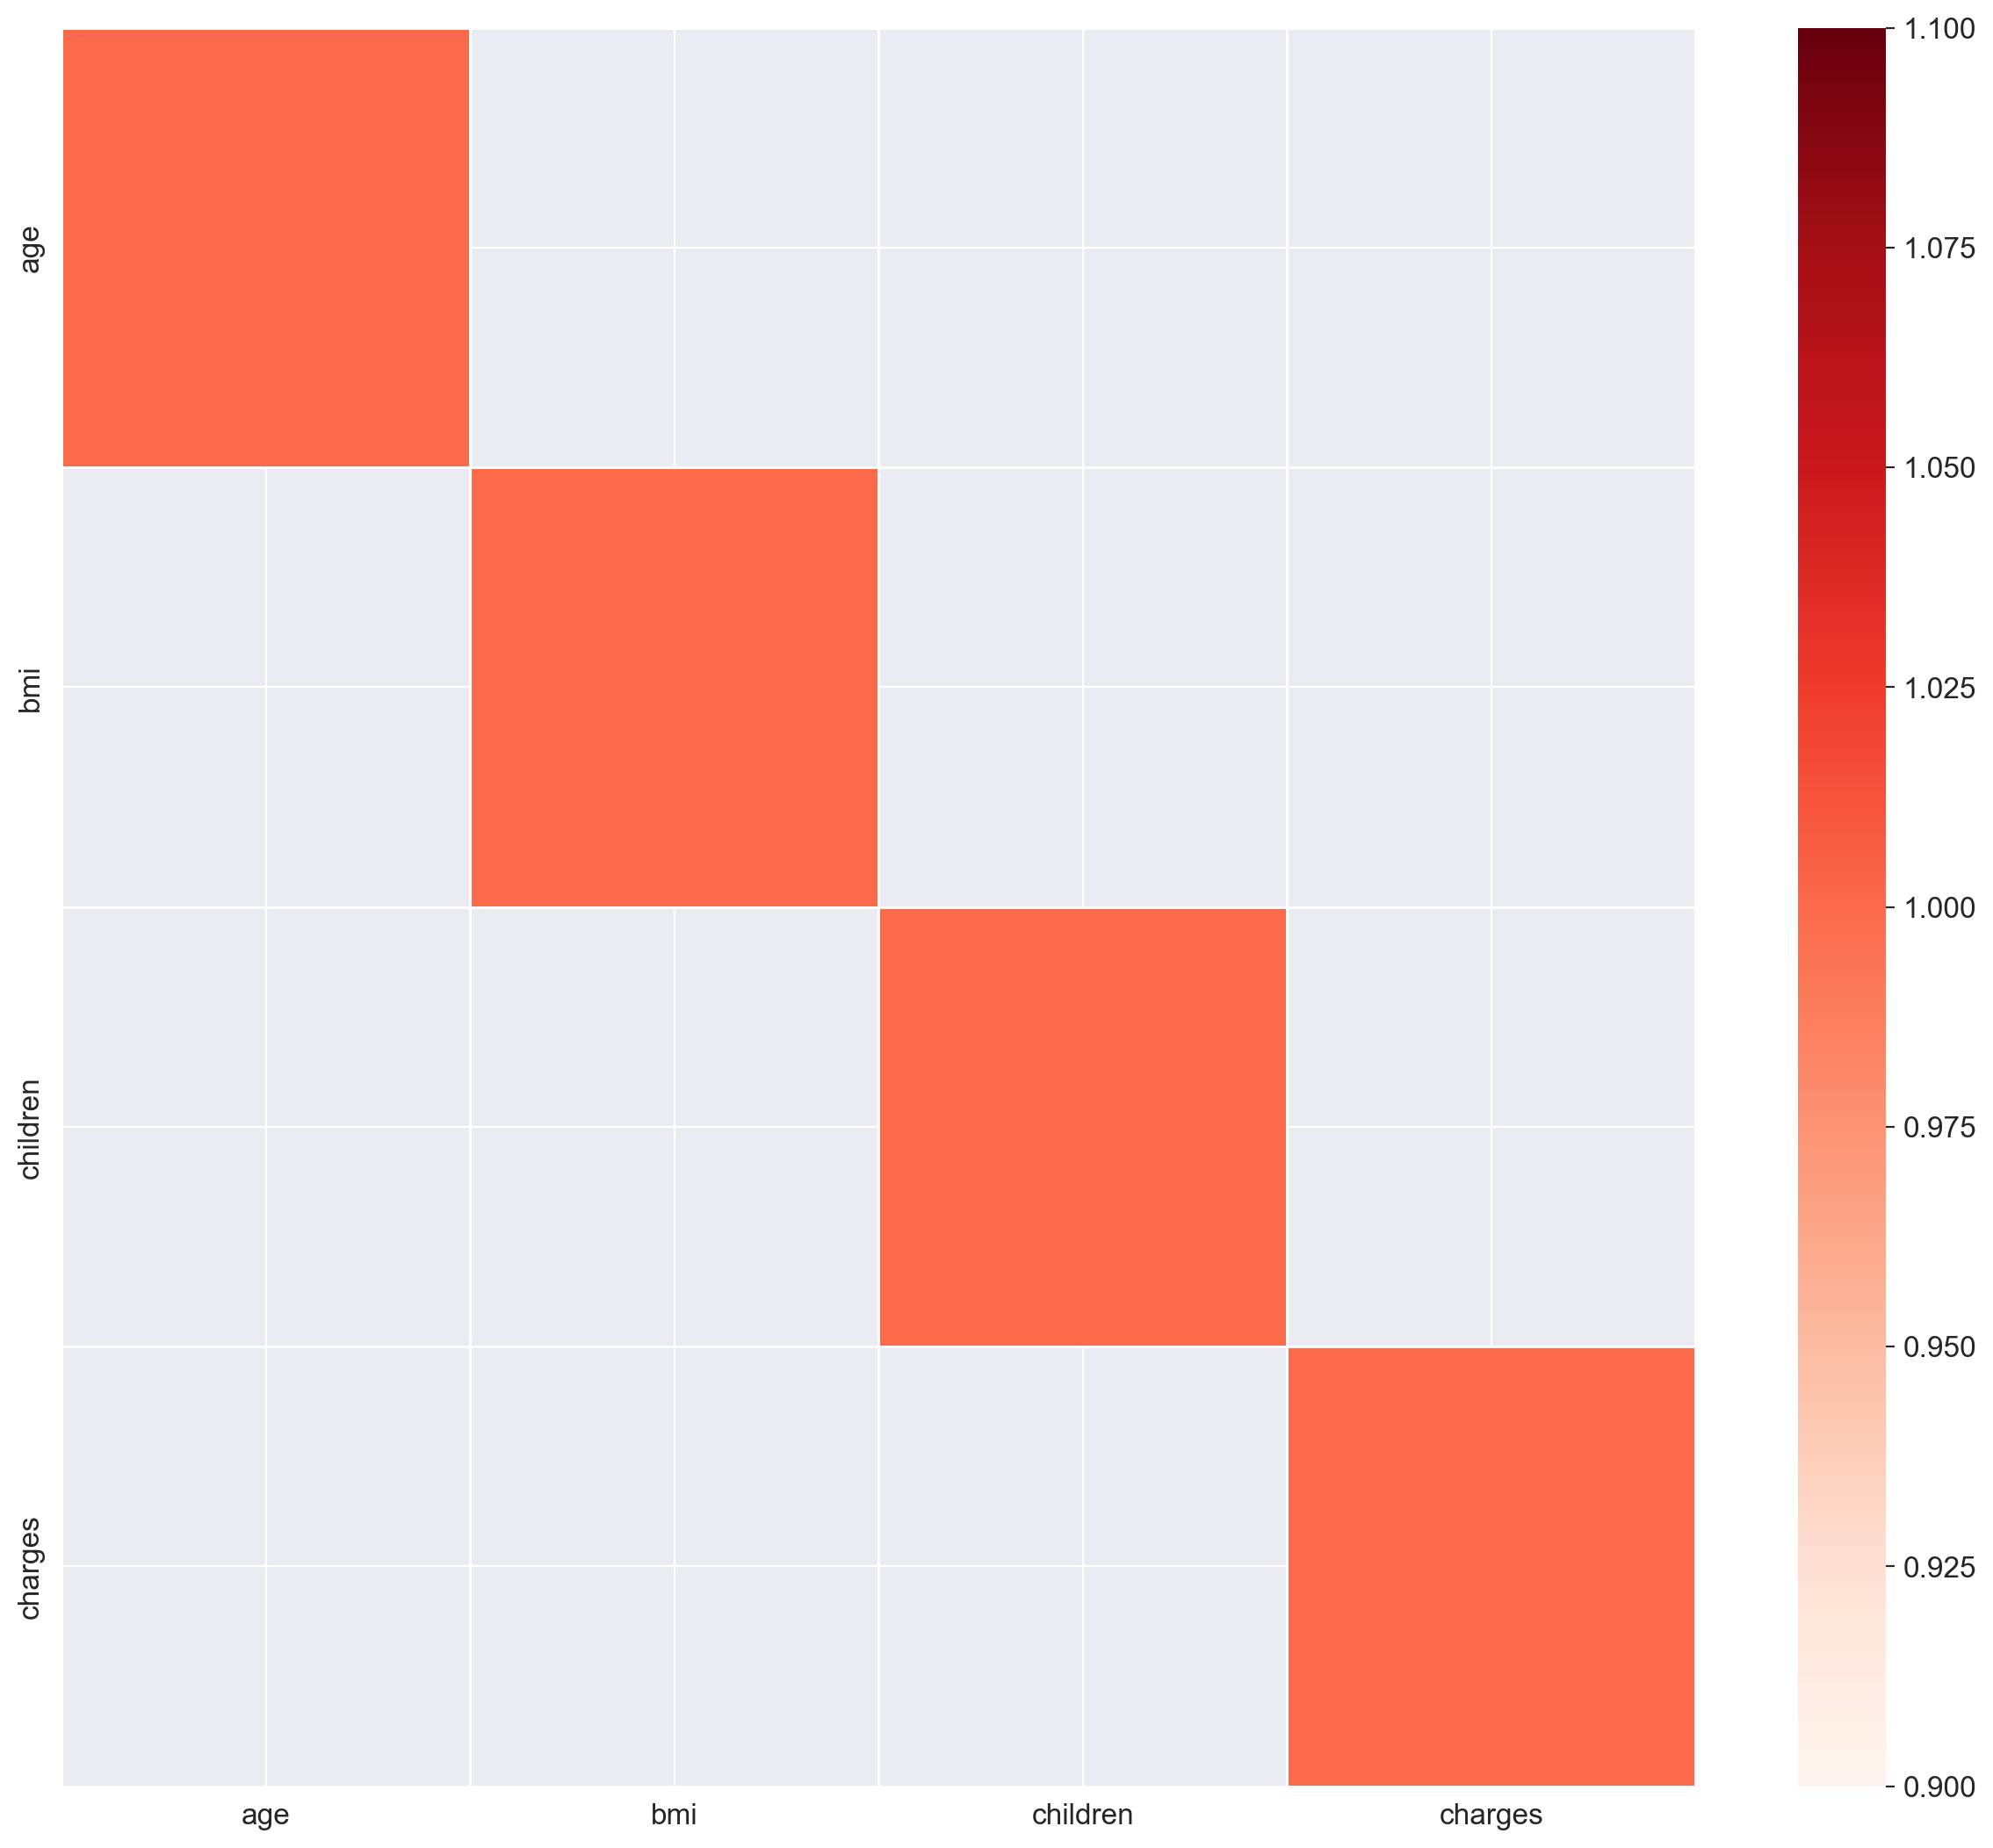

In [20]:
plt.figure(figsize=(15,13))

corr_matrix = numeric_atts.corr()
sns.heatmap(corr_matrix,mask=corr_matrix<0.75,linewidth=1,cmap='Reds')

There is no multicollinearity problem here

In [21]:
import scipy.stats as stats

# Convert 'charges' into categorical bins
train_df['charges_binned'] = pd.qcut(train_df['charges'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

chi2_values = []
p_values = []

for feature in cat_atts:
    # Creating a contingency table
    contingency_table = pd.crosstab(train_df[feature], train_df['charges_binned'])

    # Perform Chi-Square test
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    chi2_values.append(chi2_stat)
    p_values.append(p_value)

# Creating a DataFrame with results
df_chi2 = pd.DataFrame({'Feature': cat_atts.columns, 'Chi2': chi2_values, 'P-value': p_values})

# Style the table
df_chi2.head(3).style.background_gradient(cmap='Reds', axis=0)


,Feature,Chi2,P-value
0,sex,6.833660,0.077393
1,smoker,662.655689,0.000000
2,region,16.665140,0.054225


* Sex does'nt have a strong correlation with charges as the p-value is greater than 0.077
* Smoker has a high Chi2 values and low p-value which indicates a strong correlation with charges
* Region has a weak to moderate correlation with charges as its p-value is around 0.05 but not lesser than it, so it's not statistically significant

In [22]:
#Checking for nulti-collinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# One-Hot Encode Categorical Features
cat_df = pd.get_dummies(train_df[['sex', 'smoker', 'region']], drop_first=True)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = cat_df.columns
vif_data["VIF"] = [variance_inflation_factor(cat_df.values, i) for i in range(cat_df.shape[1])]

print(vif_data)


            Feature       VIF
0          sex_male  0.003051
1        smoker_yes  0.005544
2  region_northwest  0.004799
3  region_southeast  0.004454
4  region_southwest  0.004600


* The VIF for each of these features is less than 1, so no chance of multi-collinearity